In [ ]:
# This is a series of examples using the icanswim/qchem quantum mechanic machine learning repo
# icanswim/qchem utilizes the icanswim/cosmosis data science machine learning repo

In [1]:
import sys # required for relative imports in jupyter lab
sys.path.insert(0, '../') 

from cosmosis.model import FFNet
from cosmosis.dataset import SKDS
from cosmosis.learning import Learn, Selector

from dataset import QM7, QM7b, QM7X, QM9, ANI1x

from torch.optim import Adam
from torch.nn import MSELoss, L1Loss
from torch.optim.lr_scheduler import ReduceLROnPlateau

RDKit WARNING: [08:39:23] Enabling RDKit 2019.09.3 jupyter extensions


In [ ]:
## Example using scikit dataset wrapper SKDS and custom model
model_params = {'D_in': 128, 
                'H': 512, 
                'D_out': 1, 
                'model_name': 'funnel'}

ds_params = {'train_params': {'features': ['X'],
                              'targets': ['y'],
                              'features_dtype': 'float32',
                              'targets_dtype': 'float32',
                              'make': 'make_regression',
                              'transform': [],
                              'target_transform': [],
                              'sk_params': {'n_samples': 10000,
                                            'n_features': 128}}}

metrics_params = {'report_interval': 10}

opt_params = {'lr': 0.01}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7, .15)}

sched_params = {'factor': .5,
                'patience': 2,
                'cooldown': 1}

l = Learn([SKDS], FFNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=MSELoss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          batch_size=256, epochs=20)

In [ ]:
## Example using QM7 dataset and custom model with embeddings
model_params = {'D_in': 23*23+23*32, 
                'H': 4096, 
                'D_out': 1, 
                'model_name': 'funnel',
                'embed_params': [('atoms',7,32,None,True)]}



metrics_params = {'report_interval': 10}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7,.15)}

sched_params = {'factor': .5,
                'patience': 2,
                'cooldown': 1}

opt_params = {'lr': 0.01}

l = Learn([QM7], FFNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          batch_size=256, epochs=20)

In [ ]:
## Example using the QM7b dataset
model_params = {'D_in': 23*23, 
                'H': 2048, 
                'D_out': 1, 
                'model_name': 'funnel'}

ds_params = {'train_params': {'features': ['coulomb'],
                              'targets': ['E'],
                              'in_file': './data/qm7b/qm7b.mat',
                              'flatten': True}}

metrics_params = {'report_interval': 10,
                  'log_plot': False}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7,.15)}

sched_params = {'factor': .5,
                'patience': 5,
                'cooldown': 2}

opt_params = {'lr': 0.01}

l = Learn([QM7b], FFNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params, 
          batch_size=256, epochs=20)

In [ ]:
## Find the longest molecule in the QM7X dataset
ds_params = {'train_params': {'features': ['atNUM'],
                              'pad': None,
                              'targets': [],
                              'embeds': [],
                              'selector': ['opt']}}

qm7x = QM7X(**ds_params['train_params'])
l = 0
for i in qm7x.ds_idx:
    s = qm7x[i][0].shape[0]
    if s > l:
        l = s
print('longest molecule length: ', l)

qm7x[1]

In [ ]:
## Example using the QM7X dataset and custom model with embeddings
model_params = {'D_in': 23*23+23*64, 
                'H': 4096, 
                'D_out': 1, 
                'model_name': 'funnel',
                'embed_params': [('atNUM',9,64,None,True)]}

ds_params = {'train_params': {'features': ['distance'],
                              'pad': 23,
                              'do_not_pad':['eAT'],
                              'targets': ['eAT'],
                              'embeds': ['atNUM'],
                              'selector': ['opt'],
                              'flatten': True}}

metrics_params = {'report_interval': 10}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7,.15)}

sched_params = {'factor': .5,
                'patience': 5,
                'cooldown': 2}

opt_params = {'lr': 0.01}

l = Learn([QM7X], FFNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          batch_size=256, epochs=50)

creating QM9 dataset...
molecules scanned:  1
molecules removed for no rdkit conformer:  0
molecules created:  1
molecules scanned:  1001
molecules removed for no rdkit conformer:  15
molecules created:  986
molecules scanned:  2001
molecules removed for no rdkit conformer:  17
molecules created:  1984
total molecules scanned:  2023
total molecules removed for no rdkit conformer:  23
total uncharacterized molecules removed:  53
total molecules created:  1947
CDataset created...
FFNet model loaded...
CModel loaded...
running model on cpu...
learning time: 0:00:06.069178
epoch: 0, lr: 0.01
train loss: 307.6637939453125, val loss: 309.9928894042969
learning time: 0:00:18.170609
epoch: 2, lr: 0.01
train loss: 298.37461547851564, val loss: 294.6429443359375
learning time: 0:00:30.251777
epoch: 4, lr: 0.01
train loss: 265.72471313476564, val loss: 253.88009643554688
learning time: 0:00:42.441295
epoch: 6, lr: 0.01
train loss: 200.20409545898437, val loss: 177.11639404296875
learning time: 0:

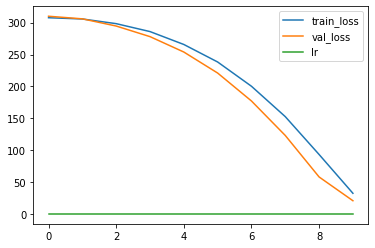

In [3]:
## Example using the QM9 dataset
model_params = {'D_in': 11+29+29*29+16*29,
                'H': 4096, 
                'D_out': 1, 
                'model_name': 'funnel',
                'embed_params': [('hybridization',9,16,0,True)]}

ds_params = {'train_params': {'n': 2000,
                              'db': 'rdkit',
                              'n_conformers': 1,
                              'features': ['A','B','C','mu',
                                           'alpha','homo','lumo','gap','r2','zpve','Cv',
                                           'mulliken','coulomb'],
                              'embeds': ['hybridization'],
                              'targets': ['U0'],
                              'pad': 29,
                              'do_not_pad': ['U0','n_atoms','A','B','C','mu',
                                             'alpha','homo','lumo','gap','r2','zpve','Cv'],
                              #'filter_on': ('n_atoms','>','18'),
                              'use_pickle': False,
                              'flatten': True}}

metrics_params = {'report_interval': 10}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7,.15)}

sched_params = {'factor': .5,
                'patience': 5,
                'cooldown': 2}

opt_params = {'lr': 0.01}

l = Learn([QM9], FFNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params, 
          batch_size=256, epochs=10, gpu=False)

In [ ]:
ds_params = {'train_params': {'n': 2000,
                              'db': 'rdkit',
                              'n_conformers': 1,
                              'features': ['A','B','C','mu',
                                           'alpha','homo','lumo','gap','r2','zpve','Cv',
                                           'mulliken','coulomb','aromatic','degree'],
                              'embeds': [],
                              'targets': ['U0'],
                              'pad': 29,
                              'do_not_pad': ['U0','n_atoms','A','B','C','mu',
                                             'alpha','homo','lumo','gap','r2','zpve','Cv'],
                              #'filter_on': ('n_atoms','>','18'),
                              'use_pickle': False,
                              'flatten': True,
                              'embed_lookup': {'0': 0, 'H': 1, 'C': 2, 'N': 3, 'O': 4, 'F': 5,
                                               'CHI_UNSPECIFIED': 6, 'CHI_TETRAHEDRAL_CW': 7,
                                               'CHI_TETRAHEDRAL_CCW':8, 'CHI_OTHER': 9, 
                                               'UNSPECIFIED': 10, 'S': 11, 'SP': 12, 
                                               'SP2': 13, 'SP3': 14, 'SP3D': 15, 'SP3D2': 16,
                                               'OTHER': 17, 'misc': 18,}}}

ds = QM9(**ds_params['train_params'])


In [ ]:
ds[1]

In [ ]:
ds[1]['X'].shape

In [ ]:
ds[1]['y'].shape

In [ ]:
## Example using the QM9 dataset filter
model_params = {'D_in': 17*17+17+12, 
                'H': 4096, 
                'D_out': 1, 
                'model_name': 'funnel'}

ds_params = {'train_params': {#'n': 10000,
                              'features': ['n_atoms','A','B','C','mu','alpha','homo','lumo', 
                                           'gap','r2','zpve','Cv','mulliken','coulomb'],
                              'embeds': [],
                              'targets': ['U0'],
                              'pad': 17,
                              'do_not_pad': ['n_atoms','A','B','C','mu','alpha','homo','lumo',
                                             'gap','r2','zpve','Cv','U0'],
                              'filter_on': ('n_atoms','<','18'),
                              'use_pickle': False,
                              'flatten': True}}

crit_params = {'reduction': 'sum'}

metrics_params = {'report_interval': 10,
                  'log_plot': True}

sample_params = {'set_seed': 88,
                 'splits': (.7,.15)}

sched_params = {'factor': .5,
                'patience': 5,
                'cooldown': 2}

opt_params = {'lr': 0.01}

l = Learn([QM9], FFNet, Selector, Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          batch_size=256, epochs=30)

In [ ]:
## Example using ANI1x dataset with filter and embeddings with a custom model
model_params = {'D_in': 63*63+63*32, 
                'H': 8192, 
                'D_out': 1, 
                'model_name': 'funnel',
                'embed_params': [('atomic_numbers',9,32,None,True)]}

ds_params = {'train_params': {'features': ['distance'],
                              'targets': ['wb97x_dz.energy'],
                              'embeds': ['atomic_numbers'],
                              'pad': 63, #length of the longest molecule in the dataset
                              'flatten': True,
                              'criterion': ['wb97x_dz.energy'],
                              'conformation': 'max',
                              'in_file': './data/ani1x/ani1x-release.h5'}}

metrics_params = {'report_interval': 20}

crit_params = {'reduction': 'sum'}
sample_params = {'set_seed': 88,
                 'splits': (.7,.15)}
sched_params = {'factor': .5,
                'patience': 5,
                'cooldown': 5}
opt_params = {'lr': 0.01}

l = Learn([ANI1x], FFNet, Selector, Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          batch_size=128, epochs=50)